<a href="https://colab.research.google.com/github/medjbersoundous/BurnoutPredictionModel/blob/main/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and explore data

In [ ]:
dataset = pd.read_csv('/content/raw_data.csv')

In [ ]:
print("Dataset shape")
dataset.shape

Dataset shape


(22750, 9)

In [ ]:
# Preview first 5 rows
print("Dataset columns")
dataset.head()

Dataset columns


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52


In [ ]:
print("Descriptive statics about the dataset:")
dataset.describe()

Descriptive statics about the dataset:


,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [ ]:
# check for consistency, missing or outlier values
dataset.tail()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1,3.0,NaN,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3,6.0,6.7,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3,7.0,NaN,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2,5.0,5.9,0.52
22749,fffe3400350031003800,2008-01-06,Male,Product,No,3,6.0,7.8,0.61


In [ ]:
# shows column types and non null counts
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  int64  
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.6+ MB


In [ ]:
print("Data quality verification: missing values, duplicate rows, unique values ")
dataset.isnull().sum().sum()

Data quality verification: missing values, duplicate rows, unique values 


np.int64(4622)

In [ ]:
# count of duplicate rows
dataset.duplicated().sum()

np.int64(0)

In [ ]:
# count of unique values per column
dataset.nunique()

,0
Employee ID,22750
Date of Joining,366
Gender,2
Company Type,2
WFH Setup Available,2
Designation,6
Resource Allocation,10
Mental Fatigue Score,101
Burn Rate,101


# Data visualisation

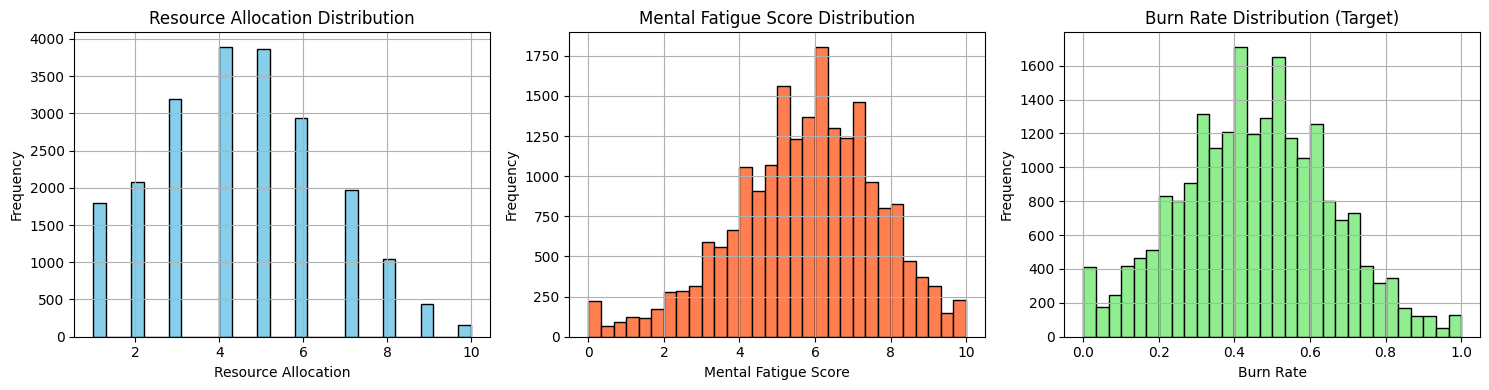

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# histogram for resource allocation
dataset['Resource Allocation'].hist(bins=30, ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_title('Resource Allocation Distribution')
axes[0].set_xlabel('Resource Allocation')
axes[0].set_ylabel('Frequency')
# histogram for mental fatigue score
dataset['Mental Fatigue Score'].hist(bins=30, ax=axes[1], edgecolor='black', color='coral')
axes[1].set_title('Mental Fatigue Score Distribution')
axes[1].set_xlabel('Mental Fatigue Score')
axes[1].set_ylabel('Frequency')
# histogram for burn rate
dataset['Burn Rate'].hist(bins=30, ax=axes[2], edgecolor='black', color='lightgreen')
axes[2].set_title('Burn Rate Distribution (Target)')
axes[2].set_xlabel('Burn Rate')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data preprocessing / feature engineering

In [ ]:
# convert date of joining to datetime
dataset['Date of Joining'] = pd.to_datetime(dataset['Date of Joining'])
# create TenureDays feature as days since joining
dataset['TenureDays'] = (pd.to_datetime('today') - dataset['Date of Joining']).dt.days

In [ ]:
dataset.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,TenureDays
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2,3.0,3.8,0.16,6278
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1,2.0,5.0,0.36,6217
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2,NaN,5.8,0.49,6482
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1,1.0,2.6,0.20,6244
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3,7.0,6.9,0.52,6346


In [ ]:
# remove rows with missing values
clean_data = dataset.dropna()

In [ ]:
# One hot encode categorical variables
dataset_encoded = pd.get_dummies(
    clean_data,
    columns=['Gender', 'Company Type', 'WFH Setup Available'],
    drop_first=False,
    dtype=int
)

In [ ]:
dataset_encoded.head()

,Employee ID,Date of Joining,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,TenureDays,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,fffe32003000360033003200,2008-09-30,2,3.0,3.8,0.16,6278,1,0,0,1,1,0
1,fffe3700360033003500,2008-11-30,1,2.0,5.0,0.36,6217,0,1,0,1,0,1
3,fffe32003400380032003900,2008-11-03,1,1.0,2.6,0.20,6244,0,1,0,1,0,1
4,fffe31003900340031003600,2008-07-24,3,7.0,6.9,0.52,6346,1,0,0,1,1,0
5,fffe3300350037003500,2008-11-26,2,4.0,3.6,0.29,6221,0,1,1,0,0,1


In [ ]:
# drop useless columns (id and date)
dataset_encoded = dataset_encoded.drop(['Employee ID', 'Date of Joining'], axis=1)

In [ ]:
dataset_encoded.shape

(18590, 11)

In [ ]:
dataset_encoded.dtypes

,0
Designation,int64
Resource Allocation,float64
Mental Fatigue Score,float64
Burn Rate,float64
TenureDays,int64
Gender_Female,int64
Gender_Male,int64
Company Type_Product,int64
Company Type_Service,int64
WFH Setup Available_No,int64


In [ ]:
dataset_encoded.columns

Index(['Designation', 'Resource Allocation', 'Mental Fatigue Score',
       'Burn Rate', 'TenureDays', 'Gender_Female', 'Gender_Male',
       'Company Type_Product', 'Company Type_Service',
       'WFH Setup Available_No', 'WFH Setup Available_Yes'],
      dtype='object')

# Prepareing data for modeling

In [ ]:
# split data into features and target
X = dataset_encoded.drop('Burn Rate', axis=1)
y = dataset_encoded['Burn Rate']

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Target (Burn Rate) statistics:")
print(y.describe())

X shape: (18590, 10)
y shape: (18590,)
Target (Burn Rate) statistics:
count    18590.000000
mean         0.452444
std          0.197848
min          0.000000
25%          0.320000
50%          0.450000
75%          0.590000
max          1.000000
Name: Burn Rate, dtype: float64


In [ ]:
# check for any remaining missing values
print("Missing values:")
print(X.isnull().sum()[X.isnull().sum() > 0])
print(f"Target missing: {y.isnull().sum()}")


Missing values:
Series([], dtype: int64)
Target missing: 0


In [ ]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7,
    shuffle=True,
    random_state=42
)

In [ ]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (13013, 10)
X_test_scaled shape: (5577, 10)


# Analysing feature correlation

In [ ]:
# feature correlations
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
print(correlations)

Mental Fatigue Score       0.944492
Resource Allocation        0.854112
Designation                0.735901
WFH Setup Available_No     0.309867
Gender_Male                0.162308
Company Type_Service       0.011489
TenureDays                -0.000476
Company Type_Product      -0.011489
Gender_Female             -0.162308
WFH Setup Available_Yes   -0.309867
dtype: float64


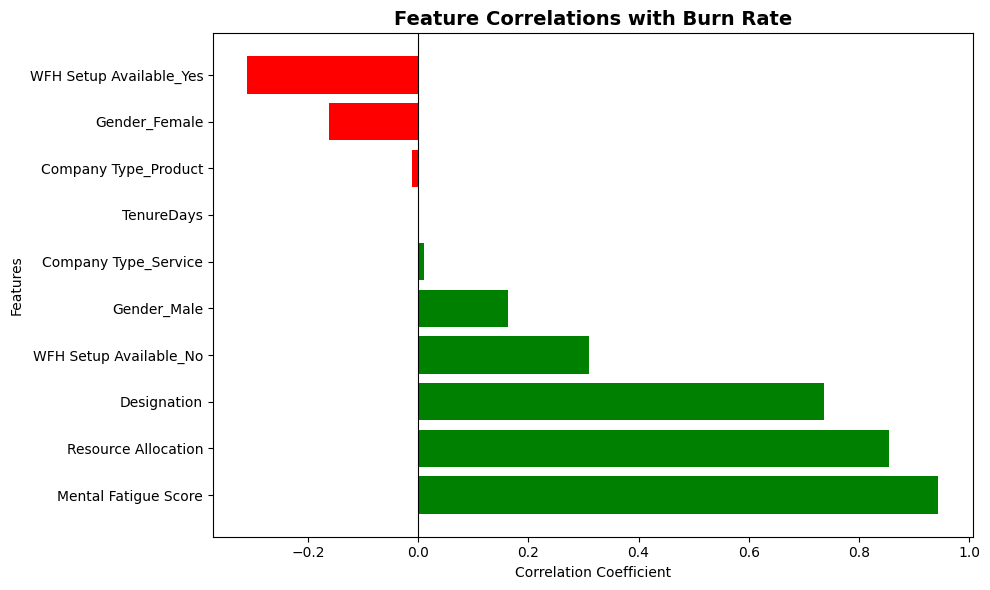

In [ ]:
# visualize correlations
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations]
plt.barh(correlations.index, correlations.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.title('Feature Correlations with Burn Rate', fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

# Building regression models for testing

In [ ]:
# define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.01, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [ ]:
results = []

In [ ]:
# train, evaluate, and cross validate models
for name, model in models.items():
    print(f"\nTraining: {name}")

    # train model
    model.fit(X_train_scaled, y_train)

    # make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # calculate regression metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # cross validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                 cv=5, scoring='r2', n_jobs=-1)

    print(f"Train R²:  {train_r2:.4f}")
    print(f"Test R²:   {test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE:  {test_rmse:.4f}")
    print(f"Test MAE:   {test_mae:.4f}")
    print(f"CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'MAE': test_mae,
        'CV R²': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })




Training: Linear Regression
Train R²:  0.9207
Test R²:   0.9206
Train RMSE: 0.0559
Test RMSE:  0.0554
Test MAE:   0.0455
CV R² (mean ± std): 0.9205 ± 0.0027

Training: Ridge
Train R²:  0.9207
Test R²:   0.9206
Train RMSE: 0.0559
Test RMSE:  0.0554
Test MAE:   0.0455
CV R² (mean ± std): 0.9205 ± 0.0027

Training: Lasso
Train R²:  0.9167
Test R²:   0.9169
Train RMSE: 0.0572
Test RMSE:  0.0567
Test MAE:   0.0461
CV R² (mean ± std): 0.9166 ± 0.0029

Training: Random Forest
Train R²:  0.9884
Test R²:   0.9162
Train RMSE: 0.0214
Test RMSE:  0.0569
Test MAE:   0.0456
CV R² (mean ± std): 0.9181 ± 0.0033

Training: Gradient Boosting
Train R²:  0.9287
Test R²:   0.9266
Train RMSE: 0.0530
Test RMSE:  0.0533
Test MAE:   0.0437
CV R² (mean ± std): 0.9264 ± 0.0028


# Model comparison

In [ ]:
# compare models
results_df = pd.DataFrame(results)
results_df.round(4)

,Model,Train R²,Test R²,Train RMSE,Test RMSE,MAE,CV R²,CV Std
0,Linear Regression,0.9207,0.9206,0.0559,0.0554,0.0455,0.9205,0.0027
1,Ridge,0.9207,0.9206,0.0559,0.0554,0.0455,0.9205,0.0027
2,Lasso,0.9167,0.9169,0.0572,0.0567,0.0461,0.9166,0.0029
3,Linear Regression,0.9207,0.9206,0.0559,0.0554,0.0455,0.9205,0.0027
4,Ridge,0.9207,0.9206,0.0559,0.0554,0.0455,0.9205,0.0027
5,Lasso,0.9167,0.9169,0.0572,0.0567,0.0461,0.9166,0.0029
6,Random Forest,0.9884,0.9162,0.0214,0.0569,0.0456,0.9181,0.0033
7,Gradient Boosting,0.9287,0.9266,0.0530,0.0533,0.0437,0.9264,0.0028


In [ ]:
# select best model based on test R²
best_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']

print(f"\n Best model: {best_model_name}")
print(f"   Test R²:   {results_df.loc[best_idx, 'Test R²']:.4f}")
print(f"   Test RMSE: {results_df.loc[best_idx, 'Test RMSE']:.4f}")
print(f"   MAE:       {results_df.loc[best_idx, 'MAE']:.4f}")


 Best model: Gradient Boosting
   Test R²:   0.9266
   Test RMSE: 0.0533
   MAE:       0.0437


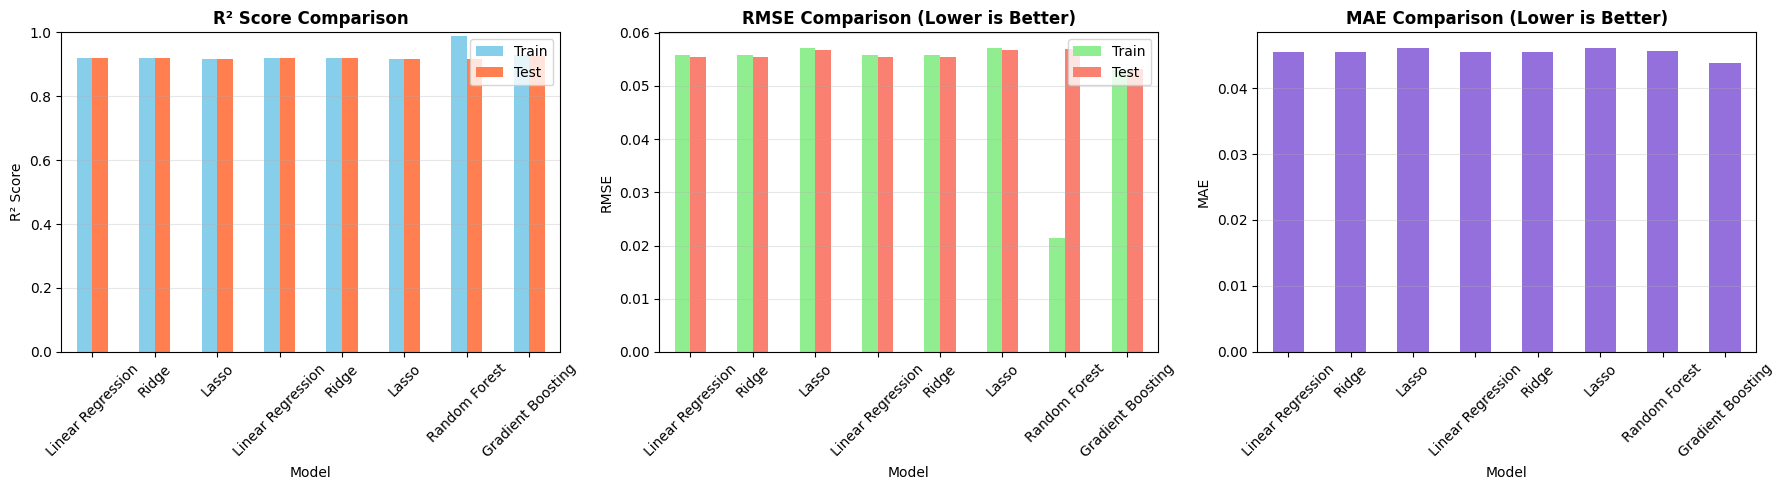

In [ ]:
# visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score comparison
results_df.plot(x='Model', y=['Train R²', 'Test R²'], kind='bar',
                ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('R² Score Comparison', fontweight='bold', fontsize=12)
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)
axes[0].legend(['Train', 'Test'])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
results_df.plot(x='Model', y=['Train RMSE', 'Test RMSE'], kind='bar',
                ax=axes[1], color=['lightgreen', 'salmon'])
axes[1].set_title('RMSE Comparison (Lower is Better)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('RMSE')
axes[1].legend(['Train', 'Test'])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# MAE comparison
results_df.plot(x='Model', y='MAE', kind='bar', ax=axes[2],
                color='mediumpurple', legend=False)
axes[2].set_title('MAE Comparison (Lower is Better)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis

In [ ]:
# feature importance for random forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance

,Feature,Importance
2,Mental Fatigue Score,0.903745
3,TenureDays,0.040548
1,Resource Allocation,0.034162
0,Designation,0.007047
9,WFH Setup Available_Yes,0.002547
8,WFH Setup Available_No,0.002468
5,Gender_Male,0.002460
4,Gender_Female,0.002358
6,Company Type_Product,0.002357
7,Company Type_Service,0.002307


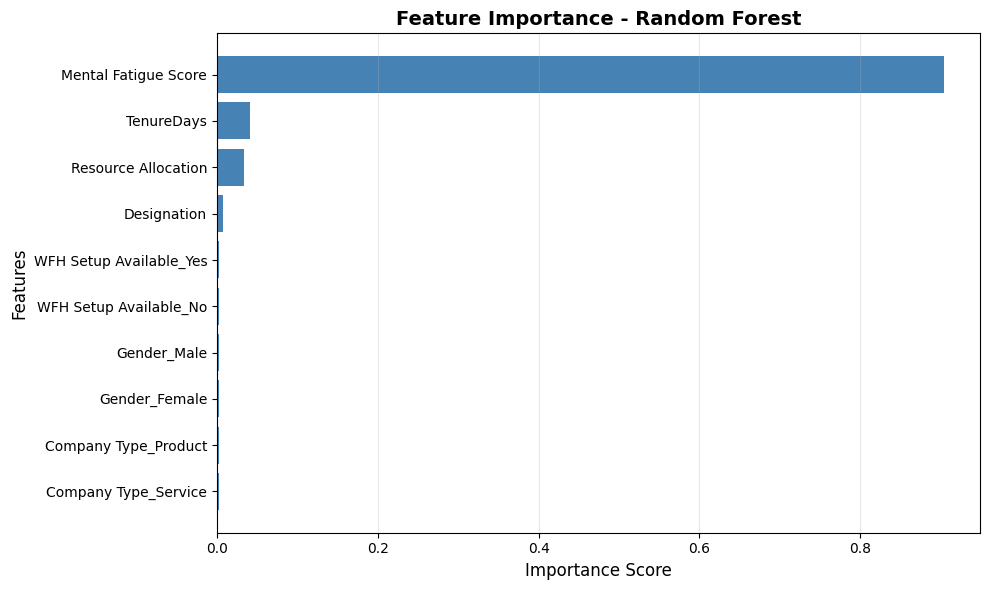

In [ ]:
# visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# Modal evaluation

In [ ]:
# residual analysis for best model
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)
residuals = y_test - y_pred

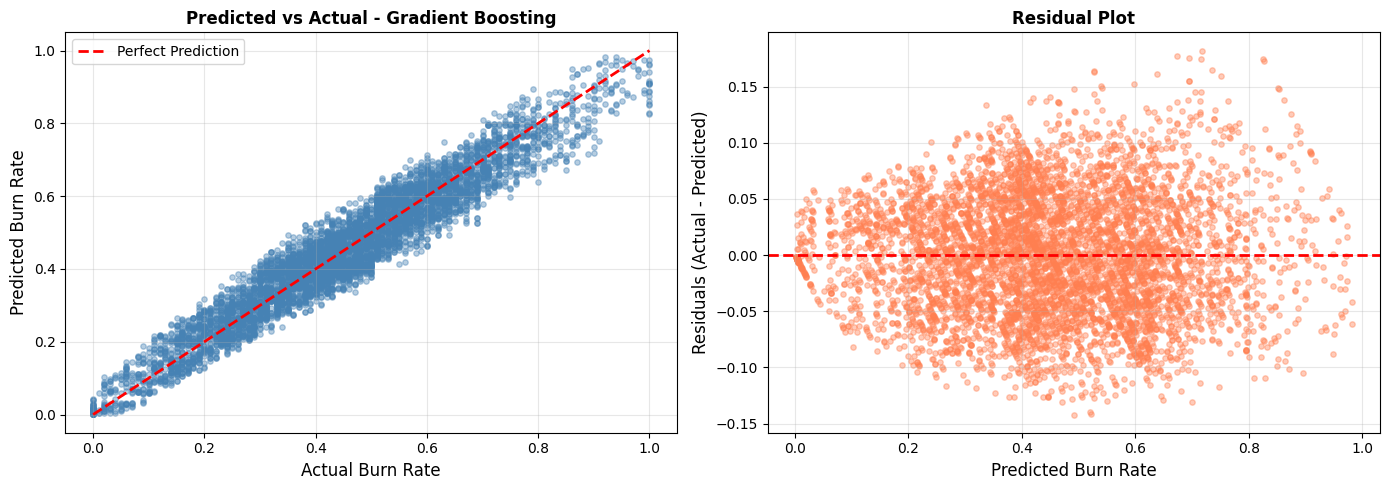

In [ ]:
# scatter plots: predicted vs actual and residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.4, s=15, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Burn Rate', fontsize=12)
axes[0].set_ylabel('Predicted Burn Rate', fontsize=12)
axes[0].set_title(f'Predicted vs Actual - {best_model_name}',
                  fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
axes[1].scatter(y_pred, residuals, alpha=0.4, s=15, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Burn Rate', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Residual distribution

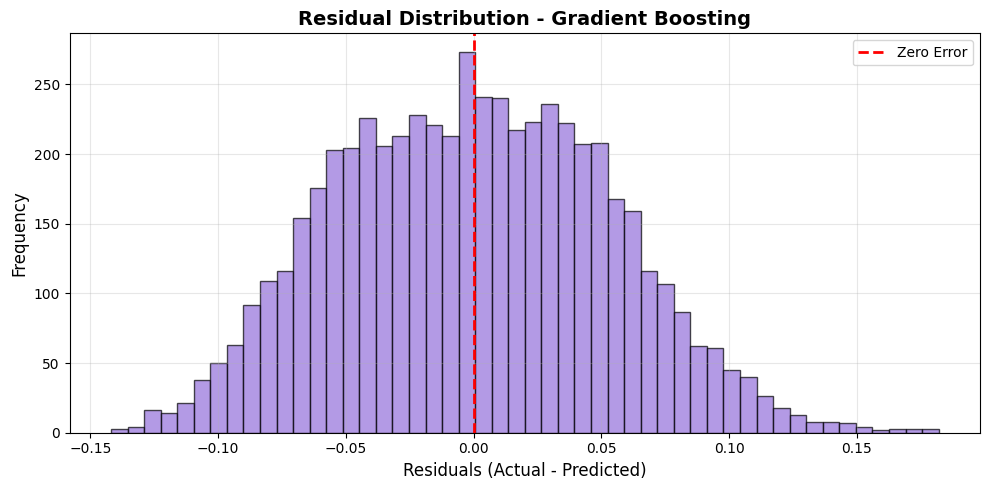

In [ ]:
# histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Residual Distribution - {best_model_name}',
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print(f"\nResidual Statistics:")
print(f"Mean:   {residuals.mean():.6f}")
print(f"Std:    {residuals.std():.4f}")
print(f"Min:    {residuals.min():.4f}")
print(f"Max:    {residuals.max():.4f}")


Residual Statistics:
Mean:   -0.000290
Std:    0.0533
Min:    -0.1419
Max:    0.1821


**Conclusion**

Gradient Boosting achieved the best performance among all models, with a Test R² of 0.9266, providing accurate and reliable predictions of Burn Rate.